In [9]:
from ADAM_multi import myADAMMultiNeuron
adam_mn = myADAMMultiNeuron(
               num_layers = 3,
               layers_config = [4,2,1],                         # num of nodes in each layer
               expressions = ['xw=ap*xp+aq*xq+ar*xr+as*xs',
                              'xz=bp*xp+bq*xq+br*xr+bs*xs',
                              'xo=cp*xw+cq*xz'],
               output_vars = ['xo'],
               dataset_size = 5000,
               learning_rate = 1e-3,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )

adam_mn.parse_multi_layer_expressions()

training_data = adam_mn.gen_training_data()
adam_mn_loss = adam_mn.train_multineuron(training_data)



self.layer_expressions:  {1: ['xw=ap*xp+aq*xq+ar*xr+as*xs', 'xz=bp*xp+bq*xq+br*xr+bs*xs'], 2: ['xo=cp*xw+cq*xz']}


[layer index: 1] all variables: {'xp', 'xw', 'xq', 'xs', 'xr', 'xz'}


[layer index: 1] learnable params: {'ap', 'ar', 'as', 'bs', 'bq', 'bp', 'aq', 'br'}


[layer index: 1] dependencies: {'xw': ['xp', 'xq', 'xr', 'xs'], 'xz': ['xp', 'xq', 'xr', 'xs']}


[layer index: 1] expressions dict: {'xw': 'ap*xp+aq*xq+ar*xr+as*xs', 'xz': 'bp*xp+bq*xq+br*xr+bs*xs'}


[layer index: 1] var_to_var_param dict: {'xw': {'xp': 'ap', 'xq': 'aq', 'xr': 'ar', 'xs': 'as'}, 'xz': {'xp': 'bp', 'xq': 'bq', 'xr': 'br', 'xs': 'bs'}}


[layer index: 1] node to int labels: {'xp': 0, 'xq': 1, 'xr': 2, 'xs': 3, 'xw': 4, 'xz': 5}


[layer index: 1] independent vars: {'xp', 'xr', 'xs', 'xq'}


[layer index: 1] leads_to dictionary: {'xp': {'xw', 'xz'}, 'xw': set(), 'xq': {'xw', 'xz'}, 'xs': {'xw', 'xz'}, 'xr': {'xw', 'xz'}, 'xz': set()}


[layer index: 2] all variables: {'xp', 'xw', 'xq', 'xs', 'xr', 'x

100%|██████████| 40000/40000 [01:48<00:00, 370.15it/s]


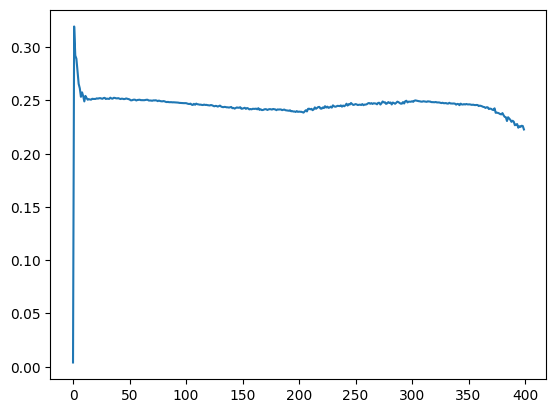

In [10]:
import matplotlib.pyplot as plt

plt.plot(sgd_mn_loss_0)